In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:

data = pd.read_csv('data_mnist.zip')

# Take only data with labels 1
data_ones = data[data['label'] == 1]

# Take only data with labels 0
data_zeros = data[data['label'] == 0]

# If you want to change either digit, just change the label value to either a 0 or a 1 so the math works out
# Ex. data_zeros = data[data['label'] == 7]
#     data_zeros['label'] = 0

# Concatenate instances with label 0 and 1
data = pd.concat([data_ones, data_zeros])
print(data.shape)
print(np.unique(data['label'].to_numpy()))

# # Split dataset with 75% training data and 25% test data
train_data, test_data = train_test_split(data, test_size=0.25, random_state=1, shuffle=True)

# Split datasets into features and labels
x_train = train_data.drop('label', axis=1).to_numpy()
x_test = test_data.drop('label', axis=1).to_numpy()
y_train = train_data['label'].to_numpy()
y_test = test_data['label'].to_numpy()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Rescale data points to values between 0 and 1 (pixels are originally 0-255)
x_train = x_train / 255.
x_test = x_test / 255.

(8816, 785)
[0 1]
(6612, 784)
(2204, 784)
(6612,)
(2204,)


In [ ]:
def shrinkdata(data, res):
    """
    Reformats the input data at a lower resolution.
    data: Our input data matrix
    res:  The resolution (must be a factor of 28)
    """
    data = data[0:].reshape([data.shape[0], 28, 28])
    data = data.reshape(data.shape[0], res, int(28 / res), res, int(28 / res)).sum(axis=2).sum(axis=3)
    data = data / ((28 / res)**2)
    data = data[0:].reshape(data.shape[0], res**2)
    return data

def shrinkpoint(data, res):
    """
    Same as shrinkdata, but for a single 784 pixel image
    """
    data = data.reshape([28, 28])
    data = data.reshape(res, int(28 / res), res, int(28 / res)).sum(axis=1).sum(axis=2)
    data = data / ((28 / res)**2)
    data = data.reshape(res**2)
    return data

This image is a 1


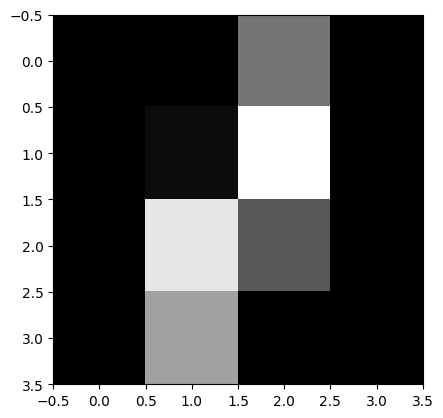

In [ ]:
import random
# from PIL import Image

i = random.randint(0, 6000)
i = 3
resolution = 4

x_shrunk = shrinkdata(x_train, resolution)
image = x_shrunk[i].reshape([resolution, resolution])

plt.imshow(image, cmap='Greys_r')
print(f'This image is a {y_train[i]}')

filename = f'imagenumber{i}_{y_train[i]}.vhd'

# print(x_shrunk[i])

# data = Image.fromarray(x_shrunk[i])
# print(type(data))
# data.save('test.png')

#Script to convert image to VHDL

This image is a 1
16


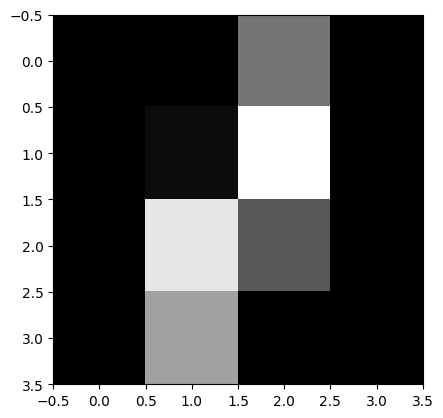

In [ ]:
i = 3
resolution = 4

x_shrunk = shrinkdata(x_train, resolution)
image = x_shrunk[i].reshape([resolution, resolution])

plt.imshow(image, cmap='Greys_r')
print(f'This image is a {y_train[i]}')

filename = f'im{i}_{y_train[i]}.vhd'

width, height = 4, 4
pixel_values = x_shrunk[i]

file = open(filename, 'w')

fileWidth = width
xCoordinate = -1
yCoordinate = 0

file.write('library IEEE;\nuse IEEE.std_logic_1164.all;\nuse IEEE.numeric_std.all;')
file.write(f'entity im{i}_{y_train[i]} is')
file.write('    port(\n')
file.write('        clk : in std_logic;\n')
file.write('        totaladr: in unsigned(3 downto 0);\n')
file.write('        grayScale : out std_logic_vector(7 downto 0)\n')
file.write('        );\n')
file.write(f'end im{i}_{y_train[i]};\n')
file.write('\n')
file.write(f'architecture synth of im{i}_{y_train[i]} is\n')
file.write('begin\n')
file.write('    process (clk) begin\n')
file.write('        if rising_edge(clk) then\n')
file.write('            case totaladr is\n')

print(len(pixel_values))

for i in range(len(pixel_values)):
    xCoordinate += 1
    if xCoordinate == fileWidth:
        yCoordinate += 1
        xCoordinate = 0

    addr = str(f'{yCoordinate:02b}') + str(f'{xCoordinate:02b}')

    grayScale = int(pixel_values[i] * 128)

    color = str(f'{grayScale:08b}')
    file.write('                when "' + addr + '" => grayScale <= "' + color + '";\n')
file.write('                when others => grayScale <= "00000000";\n')

file.write('        end case;\n')
file.write('    end if;\n')
file.write('    end process;\n')
file.write('end;\n')

file.close()

# Weight ROM Generation

In [ ]:
imageSelect = 1
width, height = 4, 4

read = open("4x4weights.txt", "r")
weight_values = []

for x in read:
  x = int(float(x) * 128)
  x = bin(x % (1<<8))
  x = x[2:]
  while len(x) < 8:
    x = '0' + x
  weight_values.append(x)

weight_values = weight_values[0:16]

print(len(weight_values))

file = open("WeightsRom.vhd", 'w')

fileWidth = width
xCoordinate = -1
yCoordinate = 0

file.write('library IEEE;\nuse IEEE.std_logic_1164.all;\nuse IEEE.numeric_std.all;')
file.write('entity WeightRom is')
file.write('    port(\n')
file.write('        clk : in std_logic;\n')
file.write('        totaladr: in unsigned(3 downto 0);\n')
file.write('        weight : out signed(7 downto 0)\n')
file.write('        );\n')
file.write('end WeightRom;\n')
file.write('\n')
file.write('architecture synth of WeightRom is\n')
file.write('begin\n')
file.write('    process (clk) begin\n')
file.write('        if rising_edge(clk) then\n')
file.write('            case totaladr is\n')


for i in range(len(weight_values)):
    xCoordinate += 1
    if xCoordinate == fileWidth:
        yCoordinate += 1
        xCoordinate = 0

    addr = str(f'{yCoordinate:02b}') + str(f'{xCoordinate:02b}')

    color = str(f'{weight_values[i]}')
    file.write('                when "' + addr + '" => weight <= "' + color + '";\n')
file.write('                when others => weight <= "00000000";\n')

file.write('        end case;\n')
file.write('    end if;\n')
file.write('    end process;\n')
file.write('end;\n')

file.close()

16
